<a href="https://colab.research.google.com/github/tvpian/NERF_Series/blob/main/NERF_Series_02_3D_Reconstruction_with_modules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import imageio

In [3]:
!unzip -q fox.zip

## Camera Dataset

In [21]:
def get_rays(datapath):
    pose_file_names = os.listdir(datapath + '/train/pose')
    intrinsic_file_names = os.listdir(datapath + '/train/intrinsics') # Paramters related to the camera
    img_file_names = [f for f in os.listdir(datapath + '/imgs') if 'train' in f]
    assert len(pose_file_names) == len(intrinsic_file_names)
    assert len(pose_file_names) == len(img_file_names)


    # Read
    N = len(pose_file_names)  # Number of images
    poses = np.zeros((N, 4, 4))  # 4x4 matrix containing the extrinsic parameters
    intrinsics = np.zeros((N, 4, 4)) # 4x4 matrix containing the intrinsic parameters
    images = []


    for i in range(N):
        pose = np.loadtxt(datapath + '/train/pose/' + pose_file_names[i]).reshape(4, 4)
        # print(pose.shape)
        intrinsic = np.loadtxt(datapath + '/train/intrinsics/' + intrinsic_file_names[i]).reshape(4, 4)
        # print(intrinsic.shape)
        img = imageio.imread(datapath + '/imgs/' + img_file_names[i])/255.0
        # print(img.shape)
        images.append(img[None])
        poses[i] = pose
        intrinsics[i] = intrinsic
    images = np.concatenate(images, axis=0)

    H = images.shape[1]
    W = images.shape[2]

    if images.shape[3] == 4: #RGBA -> RGB
        images = images[:, :, :, :3] * images[:, :, :, -1:] + (1 - images[:, :, :, -1:]) # White background has 0 opacity hence subtracting from 1 makes back to white again

    plt.imshow(images[0]) # Sample plot
    plt.show()
    # print(images.shape


    return poses, intrinsics, images





<ipython-input-21-50e6d34fd615>:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(datapath + '/imgs/' + img_file_names[i])/255.0


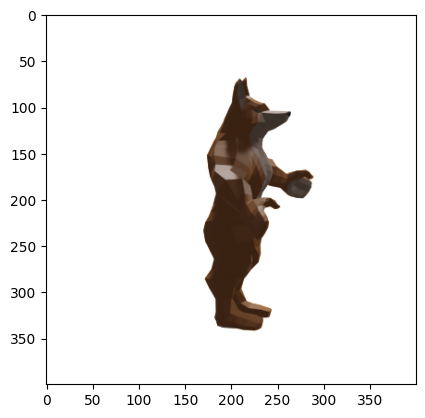

In [22]:
_,_, c = get_rays('/content/fox')

(90, 400, 400, 4)

## Rendering

## Model

## Training